### Notebook Information

Follows the code and process from the following online post
https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4

### Import Python Libraries

In [4]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

### Read Data

In [6]:
#Read in the data
ratings = pd.read_csv('Documents/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
#Get dataset info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [12]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

#Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

#Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

#List of ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [13]:
#Read in the movie data
movies = pd.read_csv('Documents/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [15]:
#Merge ratings and movies dataset 
df = pd.merge(ratings, movies, on='movieId', how='inner')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Exploratory Data Analysis (EDA)

In [19]:
#Aggregate by Movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'), number_of_ratings = ('rating','count')).reset_index()
agg_ratings.head()

#Keep the movies with over 100 ratings
agg_rating_GT100 = agg_ratings[agg_ratings['number_of_ratings'] > 100]
agg_rating_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


In [21]:
# Check Popular movies
agg_rating_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


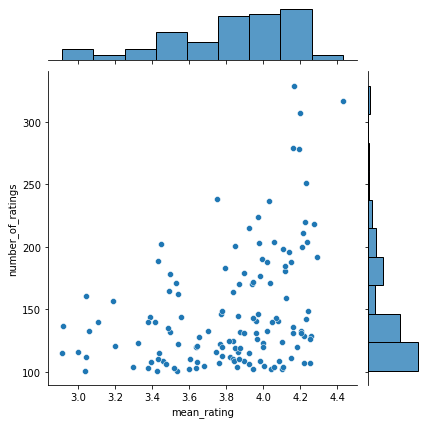

In [22]:
#Correlation between the average rating and number of ratings visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_rating_GT100)

In [27]:
#Merge data to only keep the movies with more than 100 ratings
df_GT100 = pd.merge(df, agg_rating_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 927.7+ KB


In [28]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

#Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

#Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

#List of ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Create User-Movie Matrix

In [29]:
#Transform the dataset into a matrix format with the rows being users and the columns being movies. The value of the matrix
# is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,5.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
5,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


### Data Normalization - Learn how this line of code works

In [30]:
#Since some people tend to give a higher rating than others, normalize the ranting. 
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis='rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.392857,NaN,NaN,0.607143,0.607143,NaN,-0.392857,...,NaN,NaN,NaN,-1.392857,NaN,0.607143,NaN,NaN,0.607143,0.607143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.617647,NaN,NaN,NaN,1.617647,NaN,NaN,NaN,...,NaN,NaN,-1.382353,NaN,NaN,NaN,NaN,NaN,0.617647,NaN
5,NaN,-0.461538,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.461538,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN


### Identify Similar Users